In [1]:
import psycopg2
import requests
import nbimporter
import datetime
import sys
import numpy as np
import matplotlib.pyplot as plt
import Init_database as indb
import pdb
from calendar import monthrange
from googletrans import Translator

Importing Jupyter notebook from Init_database.ipynb


In [2]:
db_name="db_teld"
user_name="postgres"
password = "ecalscraping"
host="169.229.157.40"
port="5432"
conn = indb.init_db(db_name, user_name, password, host, port)

# 1. Check connection to database

In [3]:
try:
    cur = conn.cursor()
    stmt1 = "select ST_AsText(location) from tbl_app_eachstations"
    cur.execute(stmt1)
    station_loc1 = cur.fetchall()
    stmt2 = "select ST_X(location), ST_Y(location) from tbl_app_eachstations"
    cur.execute(stmt2)
    station_loc2 = cur.fetchall()
    cur.close()
except psycopg2.Error as e:
    print(e)
print(station_loc1[0])
print(station_loc2[0])

('POINT(116.26327 39.863907)',)
(116.26327, 39.863907)


In [4]:
# #------- Request stationid which has user activities from db -------#
try:
    cur = conn.cursor()
    cur.execute("select distinct stationid from tbl_app_useractivity;")
    stationWithAct_list = cur.fetchall()
    cur.close()
except psycopg2.Error as e:
    print(e)
print("Number of stations with user activites: ", len(stationWithAct_list))
# #------- Request pilecode from db for states -------#
# staid_list = []
# for staid in stationWithAct_list:
#     staid_list.append(staid[0])
try:
    cur = conn.cursor()
#     sta_list = ['33a3c031-0a3a-417d-ba1b-53549bb08dc2']
    sta_list = ['2b3a35d4-cb94-4b8f-a47a-bbb054754066', '1d02640a-7f14-4fc3-baaf-60754a38fff7',
                'ac6cb946-5fff-491b-859e-55cc5f701657', 'dd4a3ddc-e1b0-4e2e-b7ca-faef627f4e66',
                'b134a159-16bd-4f5d-af1b-cd42599a3bab', '33a3c031-0a3a-417d-ba1b-53549bb08dc2', 
                'e4758edb-1183-4c51-887b-a52ca7abef3d', '13bdab71-110b-4448-a3c4-5c3113183546']
    #1. beijing hangkong jingmi jixie yanjiusuo chongdianzhan --'2b3a35d4-cb94-4b8f-a47a-bbb054754066',
    #2. beijing xijiao bingguan chongdianzhan -- '1d02640a-7f14-4fc3-baaf-60754a38fff7
    #3. beijing yangguanglicheng jiudian chongdianzhan --'ac6cb946-5fff-491b-859e-55cc5f701657',
    #4. beijing rongtao gongsi chongdianzhan -- '32d317a9-3d0c-4458-8357-89a2b3b1cf94'
    #5. beijing huairou qu yanshui lu -- 'dd4a3ddc-e1b0-4e2e-b7ca-faef627f4e66'
    
    #6. shenzhen hengjiang dasha chongdianzhan -- 'b134a159-16bd-4f5d-af1b-cd42599a3bab'
    #7. shenzhen yinxing gongyeyuan chongdianzhan -- '33a3c031-0a3a-417d-ba1b-53549bb08dc2'
    #8. shenzhe wanke jiulongshan chongdianzhan -- 'e4758edb-1183-4c51-887b-a52ca7abef3d'
    #9. shenzhen jingyuan dasha chongdianzhan -- '13bdab71-110b-4448-a3c4-5c3113183546'
    stmt = "select pilecode from tbl_APP_pilecode where staid in %s"
    cur.execute(stmt, (tuple(sta_list),))
    
#     stmt = "select pilecode from tbl_APP_pilecode where staid = 'dd4a3ddc-e1b0-4e2e-b7ca-faef627f4e66'"
#     cur.execute(stmt)
#     cur.execute("select pilecode from tbl_APP_pilecode")
    pillcode_list = cur.fetchall()
    cur.close()
except psycopg2.Error as e:
    print(e)
print("Nubmer of pills: ", len(pillcode_list))

('Number of stations with user activites: ', 4859)
('Nubmer of pills: ', 86)


In [91]:
# #------- Request Shenzhen charging pilecode from db for states -------#
try:
    cur = conn.cursor()
#     stmt1 = "select stationid from tbl_app_eachstations where tbl_app_eachstations.location && ST_MakeEnvelope(115.37916, 39.47148, 117.15623, 40.81726, 4326);"    
    stmt1 = "select stationid from tbl_app_eachstations where tbl_app_eachstations.location && ST_MakeEnvelope(113.85955, 22.50563, 114.17335, 22.69960, 4326) intersect select distinct stationid from tbl_app_useractivity;"
    cur.execute(stmt1)
    sta_list = cur.fetchall()
    sta_list_clean = []
    for sta in sta_list:
        sta_list_clean.append(sta[0])
except psycopg2.Error as e:
    print(e)
print("Shenzhen stations: " + str(len(sta_list_clean)))

Shenzhen stations: 77


# 2. Create a charing station object

In [6]:
class Station(object):
    "This is a station object"
    num_pills = 0
    def __init__(self, stationid, score, pricescore, servicescore, 
                 stationname, stationaddress, location):
        self.id = stationid
        self.score = score
        self.pricescore = pricescore
        self.servicescore = servicescore
        self.name = stationname
        self.addr = stationaddress
        self.GPS = location
        self.pills = []
    def add_Pill(self, pill_obj):
        self.pills.append(pill_obj)
        self.num_pills += 1
    def delete_numPills(self):
#         if self.pills >= 1:
#             self.pills -= 1
        pass
    def check_pill(self, pillcode):
        for pill in self.pills:
            #if exist return True
            if pill.pillcode == pillcode:
                return True
        return False
    def get_maxPower(self):
        maxPower = 0
        for pill in self.pills:
            if pill.isfast == "Y":
                maxPower += 60 #kw
            else:
                maxPower += 7 #kw
        return maxPower
    def get_stationName_Eng(self):
        translator = Translator()
        return translator.translate(self.name).text

# 3. Create a charging pill object

In [7]:
class Pill(Station):
    ult_data = None
    def __init__(self, pillcode, voltage, description, isfast, chargingport, power, pricedesc, prices, station):
        self.pillcode = pillcode
        self.voltage = voltage
        self.description = description
        self.isfast = isfast
        self.chargingport = chargingport
        self.power = power
        self.pricedesc = pricedesc
        self.prices = prices
        self.station = station
    def update_ultData(self, ult_data_new):
        self.ult_data = ult_data_new

# 4. Functions to request database

In [8]:
# #------- Request one pill daily utilization data from db -------#
def get_pill_daily(pillcode):
    try:
        cur = conn.cursor()
        stmt = "select statecodev3, statenamev3, time from tbl_APP_state where pillcode='{}'".format(pillcode)
        cur.execute(stmt)
        ult_data = cur.fetchall()
        cur.close()
    except psycopg2.Error as e:
        print(e)
    return ult_data

In [9]:
# #------- Request the pill details from db -------#
def get_pill_details(pillcode):
    try:
        cur = conn.cursor()
        stmt = "select voltage, description, isfast, chargingport, power, pricedesc, prices from tbl_app_piles where pillcode='{}'".format(pillcode)
        cur.execute(stmt)
        pill_details = cur.fetchall()
        cur.close()
        return pill_details
    except psycopg2.Error as e:
        print(e)

In [10]:
# #------- Request the station details from db -------#
def get_sta_details(stationid):
    try:
        cur = conn.cursor()
        stmt = "select servicescore, score, pricescore, stationname, stationaddress, ST_X(location), ST_Y(location) from tbl_app_eachstations where stationid='{}'".format(stationid)
        cur.execute(stmt)
        sta_details = cur.fetchall()
        cur.close()
    except psycopg2.Error as e:
        print(e)
    return sta_details
    

In [11]:
# #------- Request pillcodes from same station from db -------#
def get_pillcodes(stationid=sta_list[0]):
    try:
        cur = conn.cursor()
        stmt = "select pillcode from tbl_app_piles where staid='{}'".format(stationid)
        cur.execute(stmt)
        pillcode_list = cur.fetchall()
        cur.close()
    except psycopg2.Error as e:
        print(e)
    return pillcode_list

## 4.1 Get target pillcode list, pill details and station details list

In [12]:
def get_pill_station_details(sta_list):
    pillcode_list = []
    pill_details_list = []
    sta_details_list = []
    for staid in sta_list:
        pillcode_list.append(get_pillcodes(staid))
        pill_details_list.append(get_pill_details(pillcode_list[0][0][0]))
        sta_details_list.append(get_sta_details(staid))
    return pillcode_list, pill_details_list, sta_details_list

## 4.2 Example

In [13]:
# 深圳银星工业园充电站
pillcode_list_YinXing, pill_details_YinXing, sta_details_YinXing = get_pill_station_details([sta_list[-3]])

#____________________________#
#All stations in the sta_list
pillcode_list, pill_details_list, sta_details_list = get_pill_station_details(sta_list)

In [14]:
for _ in pillcode_list_YinXing[0]:
    print(_[0])
print("__________________")
print("pill details: \n")
for _ in pill_details_YinXing[0][0]:
    print(_)
print("__________________")
print("station details: \n")
for _ in sta_details_YinXing[0][0]:
    print(_)

4403060011105
4403060011103
4403060011109
4403060011201
4403060011106
4403060011203
4403060011202
4403060011108
4403060011210
4403060011102
4403060011107
4403060011110
4403060011207
4403060011209
4403060011101
4403060011104
4403060011206
4403060011205
4403060011204
__________________
pill details: 


00:00~24:00:0.700000:00~24:00:1.0000
N
国标2011 

电费:00:00~24:00:1.0000;服务费:00:00~24:00:0.7000
[{u'servicePrice': u'0.7000', u'timeRange': u'00:00-24:00', u'electricPrice': u'1.0000', u'startTime': u'00:00'}]
__________________
station details: 

3.6
4.3
3.6
深圳银星工业园充电站
广东省深圳市宝安区龙华新区观光路1301号银星高科技工业园
114.04726
22.7296


In [15]:
for _ in pillcode_list[0]:
    print(_[0])
print("__________________")
print("pill details: \n")
for _ in pill_details_list[0][0]:
    print(_)
print("__________________")
print("station details: \n")
for _ in sta_details_list[0][0]:
    print(_)

1101060331210
1101060331209
1101060331102
1101060331104
1101060331103
1101060331101
1101060331203
1101060331207
1101060331204
1101060331208
1101060331205
1101060331201
1101060331206
1101060331202
__________________
pill details: 


00:00~24:00:0.800000:00~24:00:1.2000
N
国标2011 国标2015 

电费:00:00~24:00:1.2000;服务费:00:00~24:00:0.8000
[{u'servicePrice': u'0.8000', u'timeRange': u'00:00-24:00', u'electricPrice': u'1.2000', u'startTime': u'00:00'}]
__________________
station details: 

--
--
--
北京航空精密机械研究所充电站
北京市市辖区丰台区南苑东路5号
116.407528
39.806932


# 5. Functions to construct stations and pills

In [16]:
def init_sta(stationid, score, pricescore, 
               servicescore, stationname, stationaddress, x, y):
    """
    Data cleansing + passing into Station object to initiate
    """
    location  = (x, y)
    station = Station(stationid, score, pricescore, servicescore, stationname, stationaddress, location)
    return station

In [17]:
def constr_pill(pillcode, voltage, description, isfast, 
                chargingport, power, pricedesc, prices, station):
    """
    Data cleansing + passing into Pill object to initiate
    """
    pill = Pill(pillcode, voltage, description, isfast, chargingport, power, pricedesc, prices, station)
    return pill

In [18]:
def constr_sta(pillcode_list, station):
    """
    Construct full station and pills included
    """
    for pillcode in pillcode_list:
        pill_details = get_pill_details(pillcode=pillcode[0])
        if not station.check_pill(pillcode[0]):
            pill = constr_pill(pillcode[0], pill_details[0][0], pill_details[0][1], pill_details[0][2],
                  pill_details[0][3], pill_details[0][4], pill_details[0][5], pill_details[0][6], station)
            station.add_Pill(pill)
    return station

In [19]:
def update_ultData(station):
    for pill in station.pills:
        pillcode = pill.pillcode
        ult_data = get_pill_daily(pillcode)
        pill.update_ultData(ult_data)
    return station

## 5.1 Initiate station object

In [20]:
def init_station_obj(sta_list, sta_details_list):
    staObject_list = []
    for i, staid in enumerate(sta_list):
        station_obj = init_sta(staid, sta_details_list[i][0][0], sta_details_list[i][0][1], sta_details_list[i][0][2],
                          sta_details_list[i][0][3], sta_details_list[i][0][4], sta_details_list[i][0][5], sta_details_list[i][0][6])
        staObject_list.append(station_obj)
    return staObject_list

### 5.1.1 Initiate one single station object

In [21]:
YinXing_IndustrialPark_sta =init_sta(sta_list[-3], sta_details_YinXing[0][0], 
                                     sta_details_YinXing[0][0][1], sta_details_YinXing[0][0][2],
                                     sta_details_YinXing[0][0][3], sta_details_YinXing[0][0][4], 
                                     sta_details_YinXing[0][0][5], sta_details_YinXing[0][0][6])

### 5.1.2 Initiate a list of station object

In [22]:
staObject_list = []
for i, staid in enumerate(sta_list):
    station_obj = init_sta(staid, sta_details_list[i][0][0], sta_details_list[i][0][1], sta_details_list[i][0][2],
                      sta_details_list[i][0][3], sta_details_list[i][0][4], sta_details_list[i][0][5], sta_details_list[i][0][6])
    staObject_list.append(station_obj)

## 5.2 Construct full station object

In [23]:
def constr_station_objFull(staObject_list, pillcode_list):
    for i, pillcodes in enumerate(pillcode_list):
        staObject_list[i] = constr_sta(pillcodes, staObject_list[i])
    return staObject_list

### 5.2.1 Construct a single station object full with pills included

In [24]:
YinXing_IndustrialPark_sta = constr_station_objFull([YinXing_IndustrialPark_sta], pillcode_list_YinXing)
YinXing_IndustrialPark_sta = constr_sta(pillcode_list_YinXing[0], YinXing_IndustrialPark_sta[0])
##-----YinXing_IndustrialPark_sta is a station object now not a list.
print(YinXing_IndustrialPark_sta.num_pills)

19


### 5.2.2 Construct a list of station objects full with pills included

In [25]:
staObject_list = constr_station_objFull(staObject_list, pillcode_list)
for i, pillcodes in enumerate(pillcode_list):
    staObject_list[i] = constr_sta(pillcodes, staObject_list[i])
    print(staObject_list[i].num_pills)

14
8
12
6
2
19
15
10


## 5.3 Update daily utilization data for the station

In [26]:
def update_daily_ultData(staObject_list):
    """
        Takes in a list of station
        Returns a list if list length > 1, a station object if length = 0
    """
    if len(staObject_list) == 1:
        return update_ultData(staObject_list[0])
    else:
        for i in range(len(staObject_list)):
            staObject_list[i] = update_ultData(staObject_list[i])
        return staObject_list

### 5.3.1 Update daily utilization data for a single station

In [27]:
YinXing_IndustrialPark_sta = update_daily_ultData([YinXing_IndustrialPark_sta])
YinXing_IndustrialPark_sta = update_ultData(YinXing_IndustrialPark_sta)
print(YinXing_IndustrialPark_sta.pills[0].ult_data[0][2])

2017-09-10 23:35:34.441082-07:00


### 5.3.2 Update daily utilization data for a list of stations

In [28]:
staObject_list = update_daily_ultData(staObject_list)

In [29]:
# for i in range(len(staObject_list)):
#     staObject_list[i] = update_ultData(staObject_list[i])

In [30]:
print(staObject_list[0].pills[0].ult_data[0][2])
print(staObject_list[0].name)

2017-09-10 23:07:42.807157-07:00
北京航空精密机械研究所充电站


# 6. Data Visualization - Plotting

In [31]:
def convert_day(date_power_sta_list):
    """
    Map all the day of the dates to the same day to plot
    """
    if len(date_power_sta_list[0]) > 0:
        day = date_power_sta_list[0][0].day
        month = date_power_sta_list[0][0].month
        for i in range(1, len(date_power_sta_list)):
            for j in range(len(date_power_sta_list[i])):
                date_power_sta_list[i][j] = date_power_sta_list[i][j].replace(day=day)
                date_power_sta_list[i][j] = date_power_sta_list[i][j].replace(month=month)
    return date_power_sta_list

In [32]:
def create_timeOfDay(date_power_sta_list, timestamp=15):
    """
    timestamp - assuming multiple of 15 (minutes)
    """
    if len(date_power_sta_list[0]) > 0:
        timeOfDay = []
        pts_per_min = int(60/timestamp)
        minutes = [timestamp*i for i in range(pts_per_min)]
        year = date_power_sta_list[0][0].year
        month = date_power_sta_list[0][0].month
        day = date_power_sta_list[0][0].day
        for i in range(24):
            for minute in minutes:
                date_obj = datetime.datetime(year, month, day, i, minute, 0, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None))
                timeOfDay.append(date_obj)
    return timeOfDay

In [62]:
def find_timeIdx(dateTime, timestamp=15):
    """
    timestamp - assuming multiple of 15 (minutes)
    Boundaries and intervals:
        52:31 -- [00:00] -- 7:30 --> Index 0 
        7:31 -- [15:00] -- 22:30 --> Index 1
        22:31 -- [30:00] -- 37:30 --> Index 2
        37:31 -- [45:00] -- 52:30 --> Index 3
    """
    if dateTime.tzinfo._offset.seconds == 61200:
        offset = -420
    elif dateTime.tzinfo._offset.seconds == 57600:
        offset = -480
    if timestamp == 15:
#         pdb.set_trace()
        if dateTime.day - 1 == 0:
            if dateTime.month - 1 == 0:
                # First interval of a new calendar year
                if dateTime.hour == 0 and datetime.datetime(dateTime.year-1, 12, 31, 23, 52, 31, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 7, 30, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)):
                    return 0
            else:
                # First interval of a new month
                dayEnd = monthrange(dateTime.year, dateTime.month-1)[-1]
                if dateTime.hour == 0 and datetime.datetime(dateTime.year, dateTime.month-1, dayEnd, 23, 52, 31, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 7, 30, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)):
                    return 0
        if dateTime.hour == 0 and datetime.datetime(dateTime.year, dateTime.month, dateTime.day-1, 23, 52, 31, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 7, 30, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)):
            # If dateTime is in the first interval but involves previous day as boundary
            return 0
        elif dateTime.hour != 0 and datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour-1, 52, 31, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 7, 30, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)):
            return dateTime.hour*4
        else:
            if datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 7, 31, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 22, 30, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)): 
                return dateTime.hour*4 + 1
            elif datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 22, 31, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 37, 30, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)): 
                return dateTime.hour*4 + 2
            else: 
                return dateTime.hour*4 + 3
    elif timestamp == 30:
        if dateTime.day - 1 == 0:
            if dateTime.month - 1 == 0:
                # First interval of a new calendar year
                if dateTime.hour == 0 and datetime.datetime(dateTime.year-1, 12, 31, 23, 45, 1, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 15, 0, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)):
                    return 0
            else:
                # First interval of a new month
                dayEnd = monthrange(dateTime.year, dateTime.month-1)[-1]
                if dateTime.hour == 0 and datetime.datetime(dateTime.year, dateTime.month-1, dayEnd, 23, 45, 1, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 15, 0, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)):
                    return 0
        if dateTime.hour == 0 and datetime.datetime(dateTime.year, dateTime.month, dateTime.day-1, 23, 45, 1, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 15, 0, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)):
            # If dateTime is in the first interval but involves previous day as boundary
            return 0
        elif dateTime.hour != 0 and datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour-1, 45, 1, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 15, 0, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)):
            return dateTime.hour*2
        else:
            if datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 15, 0, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 45, 1, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)): 
                return dateTime.hour*2 + 1
            else:
                if dateTime.hour == 23:
                    return dateTime.hour*2 + 1
                return dateTime.hour*2 + 2

In [63]:
def map_powerOfDay(date_power_sta_list, occupy_power_sta_list, length_prior_list, timestamp=15):
    """
    timestamp - assuming multiple of 15 (minutes)
    """
    buckets = int(24*60/timestamp)
    timeOfPower = [[] for i in range(buckets)]
    for pwr_counter, occupy_power_sta in enumerate(occupy_power_sta_list):
        for time_counter, date in enumerate(date_power_sta_list[pwr_counter]):
            try:
                index = find_timeIdx(date, timestamp)
#                 pdb.set_trace()
                timeOfPower[index].append(occupy_power_sta[length_prior_list[pwr_counter]:length_prior_list[pwr_counter]+len(date_power_sta_list[pwr_counter])][time_counter])
            except:
                print(date)
                print(sys.exc_info())
    return timeOfPower

In [35]:
def get_avg_timeOfPower(timeOfPower, timestamp=15):
    """
    timestamp - assuming multiple of 15 (minutes)
    """
    buckets = int(24*60/timestamp)
    avg_timeOfPower = []
    for i in range(buckets):
        if sum(timeOfPower[i]) == 0:
            timeOfPower[i] = [0]
    #     print(timeOfPower[i])
        avg_timeOfPower.append(np.average(timeOfPower[i]))
    return avg_timeOfPower

## 6.1 Operation Code Plot

4937
4937


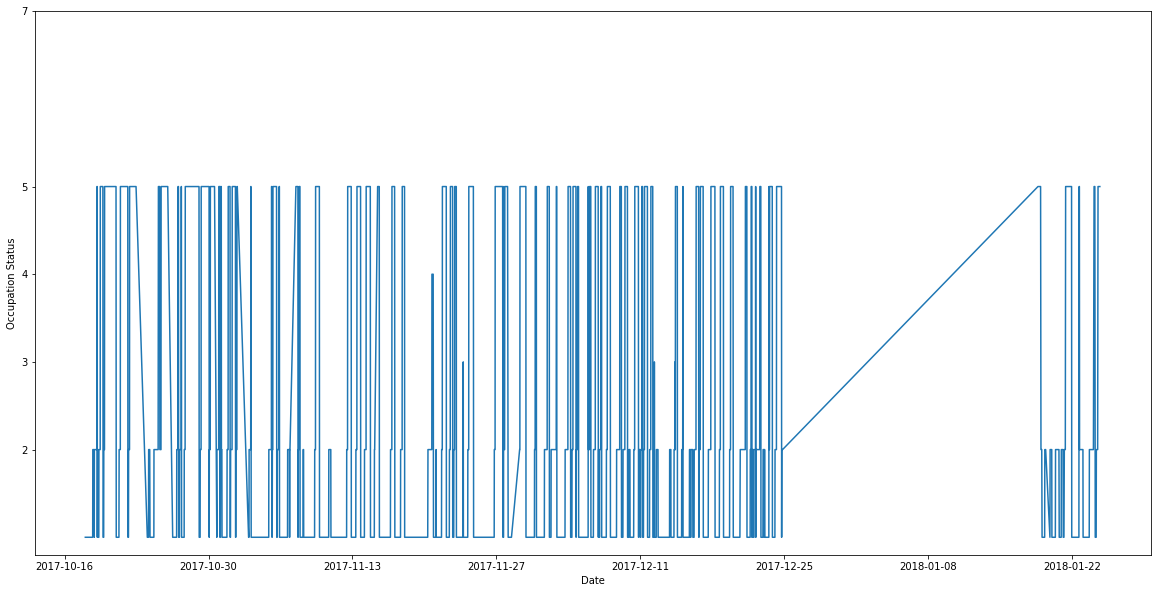

In [37]:
day_lowerBound = 18

occupy_code = [int(data[0]) for data in YinXing_IndustrialPark_sta.pills[0].ult_data if 
          datetime.datetime(2017, 10, day_lowerBound, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None)) < data[2]]
date_code = [data[2] for data in YinXing_IndustrialPark_sta.pills[0].ult_data if 
        datetime.datetime(2017, 10, day_lowerBound, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None)) < data[2]]
print(len(occupy_code))
print(len(date_code))

plt.figure(1, figsize=(20,10))
plt.plot(date_code, occupy_code)
plt.xlabel("Date")
plt.ylabel("Occupation Status")
plt.yticks(np.linspace(2,7,5,dtype=int))
plt.show()

## 6.2 Operation Power Plot - one single pill

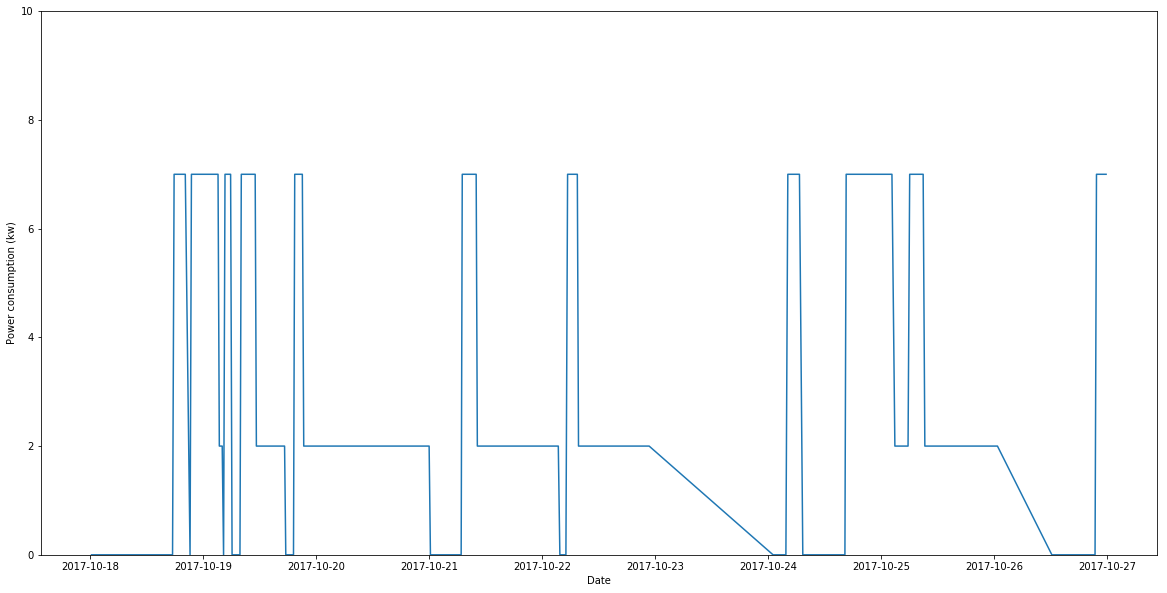

In [35]:
day_lowerBound = 18
day_upperBound = 27

occupy_power_pill = []
power_01 = 0
power_02 = 7
power_05 = 2
date_lowerBound = datetime.datetime(2017, 10, day_lowerBound, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None))
date_upperBound = datetime.datetime(2017, 10, day_upperBound, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None)) 
for data in YinXing_IndustrialPark_sta.pills[0].ult_data:
    if int(data[0]) == 1 and  date_lowerBound < data[2] and date_upperBound > data[2]:
            occupy_power_pill.append(power_01)
    elif int(data[0]) == 2 and date_lowerBound < data[2] and date_upperBound > data[2]:
            occupy_power_pill.append(power_02)
    elif int(data[0]) == 5 and date_lowerBound < data[2] and date_upperBound > data[2]:
            occupy_power_pill.append(power_05)
date_power_pill = [data[2] for data in YinXing_IndustrialPark_sta.pills[0].ult_data if 
        date_lowerBound < data[2] and date_upperBound > data[2]]

plt.figure(2, figsize=(20,10))
plt.plot(date_power_pill, occupy_power_pill)
plt.xlabel("Date")
plt.ylabel("Power consumption (kw)")
plt.ylim((0,10))
plt.show()

## 6.3 Operation Power Plot - one station

In [235]:
# Check number of data before a time
def check_num_prior(station, date_upperBound):
    length_prior = []
    for pill in station.pills:
        length = 0
        for data in pill.ult_data:
            if data[2] < date_upperBound:
                length+=1
        length_prior.append(length)
    return max(length_prior)
# Check number of data in one period
def check_num_btw(station, date_lowerBound, date_upperBound):
    length_period = []
    for pill in station.pills:
        length = 0
        for data in pill.ult_data:
            if date_lowerBound < data[2] and date_upperBound > data[2]:
                length+=1
        length_period.append(length)
    print("max in between length: ",max(length_period))
    return max(length_period)
# Total utilization data length
def check_num_tot(station):
    length_total = []
    for pill in station.pills:
        length_total.append(len(pill.ult_data))
    return max(length_total)

In [37]:
day_lowerBound = 19
day_upperBound = 21

date_lowerBound = datetime.datetime(2017, 10, day_lowerBound, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None))
date_upperBound = datetime.datetime(2017, 10, day_upperBound, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None))
station = YinXing_IndustrialPark_sta
length_prior = check_num_prior(station, date_lowerBound)

# date_lowerBound = datetime.datetime(2017, 10, 18, 12, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None))
# date_upperBound = datetime.datetime(2017, 10, 23, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None))
# length_period = check_num_btw(YinXing_IndustrialPark_sta, date_lowerBound, date_upperBound)

length_total = check_num_tot(station)

occupy_power_sta = np.zeros(length_total)
power_01 = 0
#ac charger power
power_ac_02 = 7  #kw
power_ac_05 = 2  #kw
#dc charge power
power_dc_02 = 40 #kw
power_dc_05 = 15 #kw

for pill in station.pills:
    for i, data in enumerate(pill.ult_data):
        if int(data[0]) == 1 and  date_lowerBound < data[2] and date_upperBound > data[2]:
            occupy_power_sta[i]+=(power_01)
        elif int(data[0]) == 2 and date_lowerBound < data[2] and date_upperBound > data[2]:
            if len(pill.power) is 0:
                occupy_power_sta[i]+=(power_ac_02)
            else:
                occupy_power_sta[i]+=(power_ac_02)
        elif int(data[0]) == 5 and date_lowerBound < data[2] and date_upperBound > data[2]:
            if len(pill.power) is None:
                occupy_power_sta[i]+=(power_ac_05)
            else:
                occupy_power_sta[i]+=(power_ac_05)
date_power_sta = [data[2] for data in station.pills[0].ult_data if 
            date_lowerBound < data[2] and date_upperBound > data[2]]

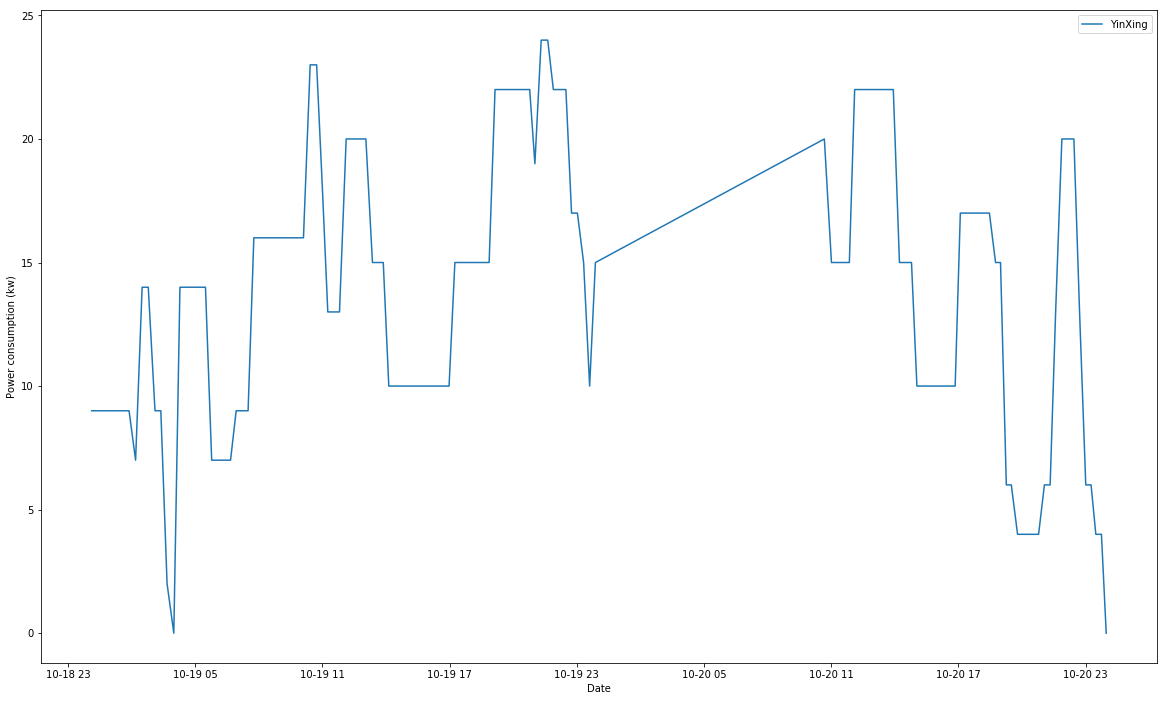

In [38]:
plt.figure(2, figsize=(20,12))
plt.plot(date_power_sta, occupy_power_sta[length_prior:length_prior+len(date_power_sta)], label="YinXing")
plt.xlabel("Date")
plt.ylabel("Power consumption (kw)")
plt.legend()
plt.show()

## 6.3 Operation Power Plot - eight stations

In [39]:
day_lowerBound = 10
day_upperBound = 17
date_upperBound = datetime.datetime(2017, 10, day_lowerBound, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None))

# occupy_power_sta = [np.zeros(max(length_total_list))]*len(sta_list)

# for station in staObject_list:
#     length_prior = check_num_prior(station, date_upperBound)
#     length_prior_list.append(length_prior)
# print("max prior length: ", max(length_prior_list))

length_total_list = []
for station in staObject_list:
    length_total = check_num_tot(station)
    length_total_list.append(length_total)
print("max total length: ", max(length_total_list))


occupy_power_sta = np.zeros(length_total)
power_01 = 0
#ac charger power
power_ac_02 = 7  #kw
power_ac_05 = 2  #kw
#dc charge power
power_dc_02 = 40 #kw
power_dc_05 = 15 #kw
date_lowerBound = datetime.datetime(2017, 10, day_lowerBound, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None))
date_upperBound = datetime.datetime(2017, 10, day_upperBound, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None))

occupy_power_sta_list = []
date_power_sta_list = []
length_prior_list = []
for counter, station in enumerate(staObject_list):
# for counter in range(1,3):
    length_prior_list.append(check_num_prior(station, date_lowerBound))
    length_total = check_num_tot(station)
    occupy_power_sta = np.zeros(length_total)
    
    for pill in station.pills:
#     for pill in staObject_list[counter].pills:
        for i, data in enumerate(pill.ult_data):
            if int(data[0]) == 1 and date_lowerBound < data[2] and date_upperBound > data[2]:
                occupy_power_sta[i]+=(power_01)
#                 print("counter is ", counter)
#                 print("i is ", i)
#                 print(occupy_power_sta[counter][i])
            elif int(data[0]) == 2 and date_lowerBound < data[2] and date_upperBound > data[2]:
                if len(pill.power) is 0:
                    occupy_power_sta[i]+=(power_ac_02)
                else:
                    occupy_power_sta[i]+=(power_dc_05)
            elif int(data[0]) == 5 and date_lowerBound < data[2] and date_upperBound > data[2]:
                if len(pill.power) is None:
                    occupy_power_sta[i]+=(power_ac_05)
                else:
                    occupy_power_sta[i]+=(power_dc_05)
    occupy_power_sta_list.append(occupy_power_sta)
    date_power_sta = [data[2] for data in station.pills[0].ult_data if 
            date_lowerBound < data[2] and date_upperBound > data[2]]
    date_power_sta_list.append(date_power_sta)

('max total length: ', 7485)


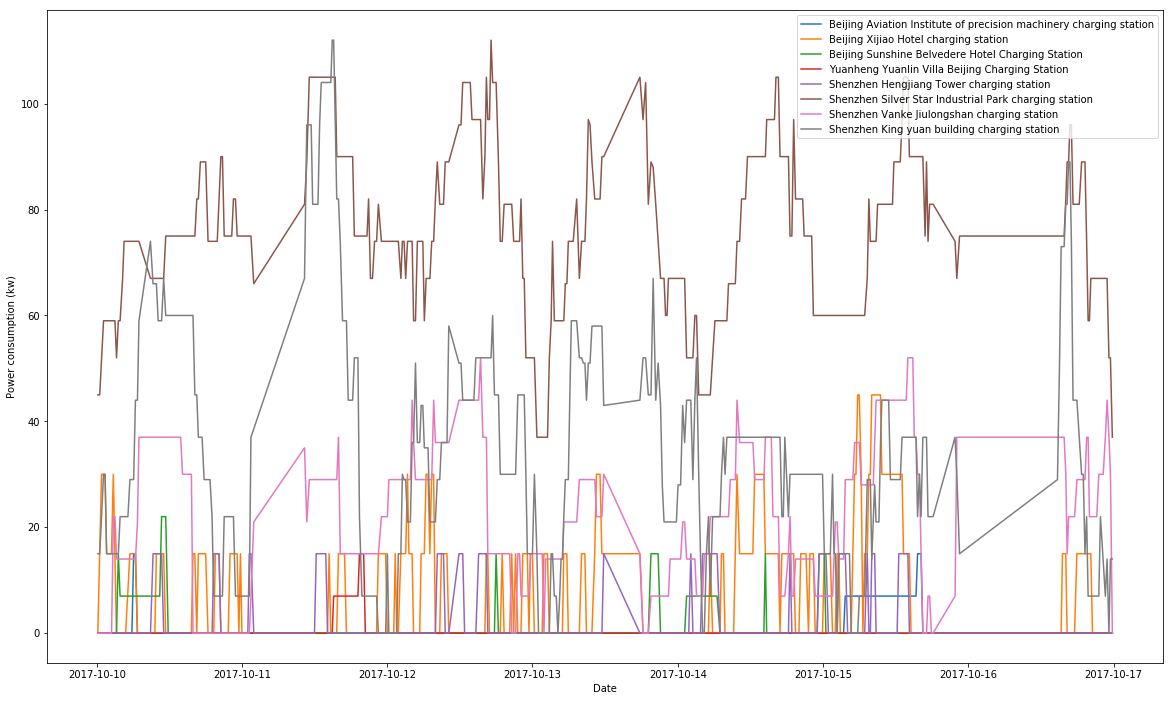

北京航空精密机械研究所充电站


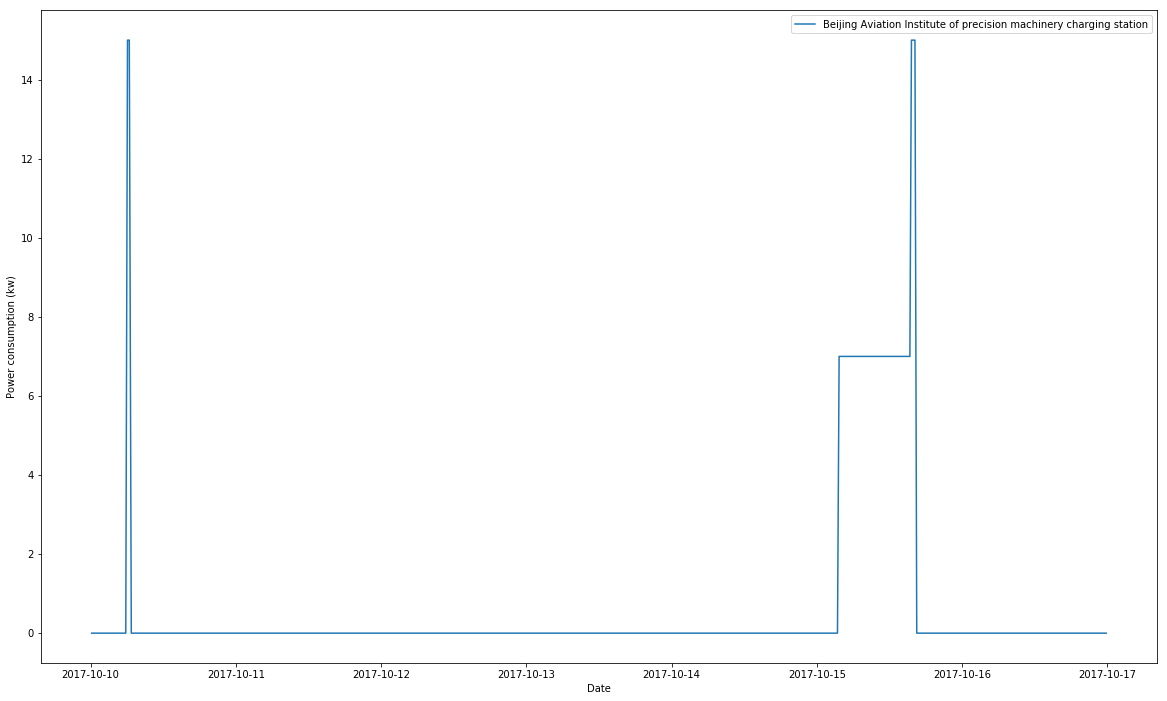

北京西郊宾馆充电站


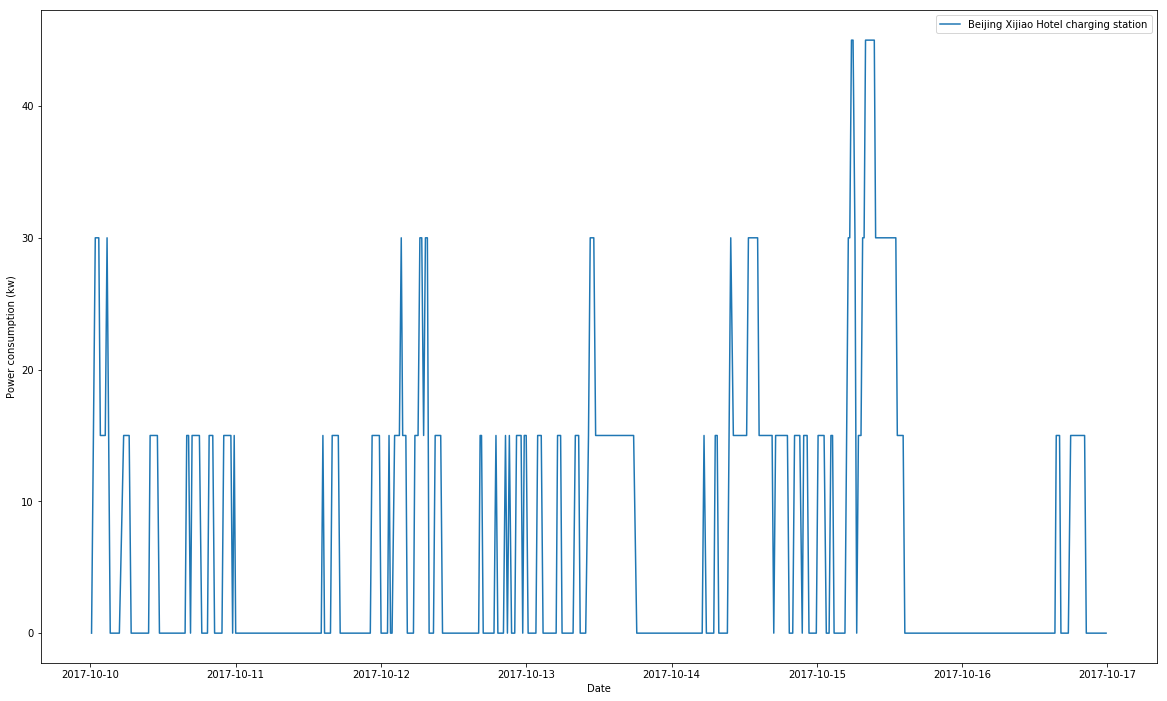

北京阳光丽城酒店充电站


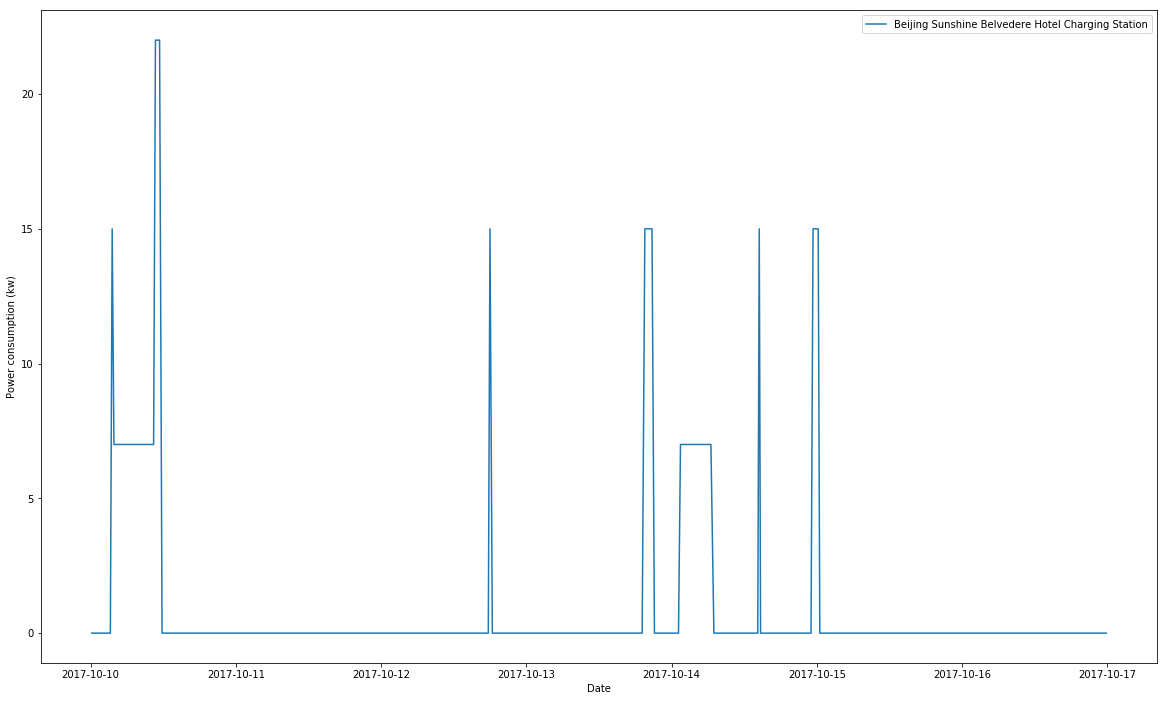

北京元亨苑林山庄有限公司充电站


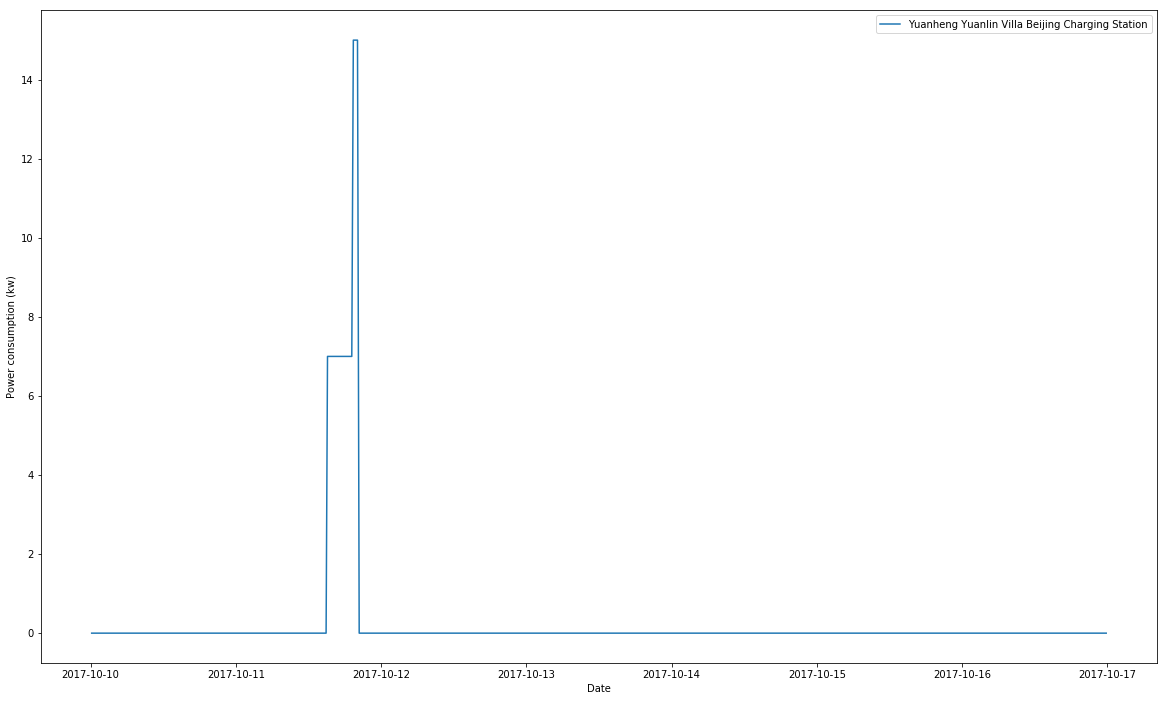

深圳恒江大厦充电站


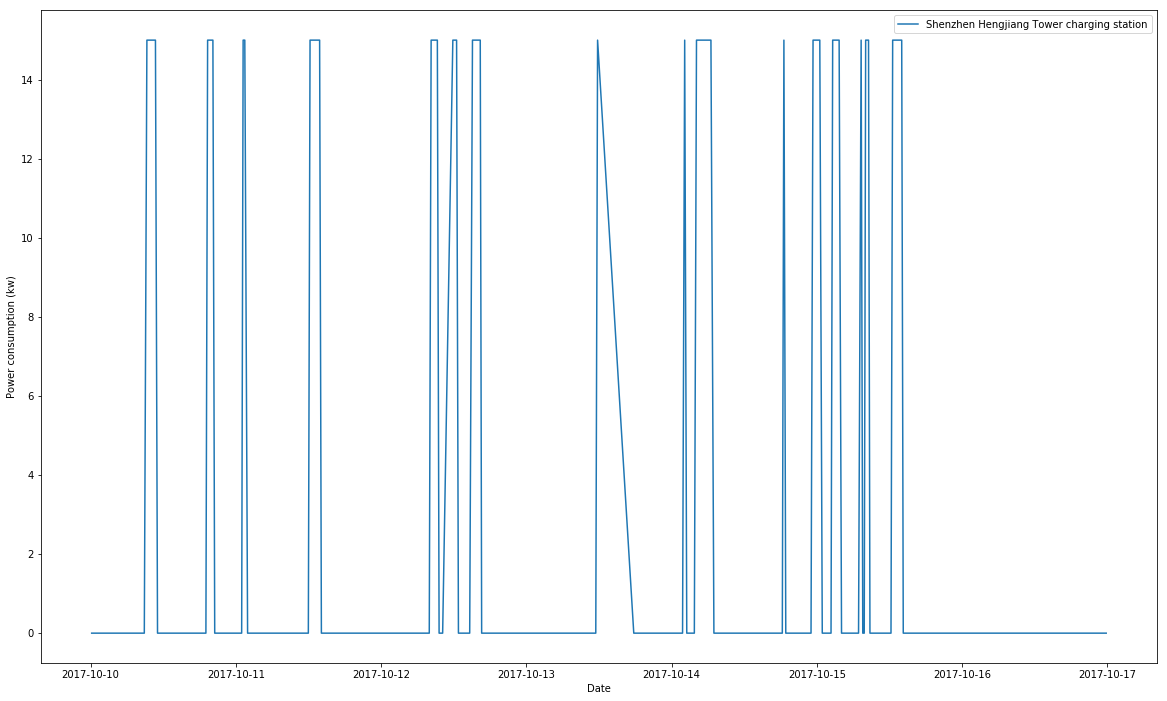

深圳银星工业园充电站


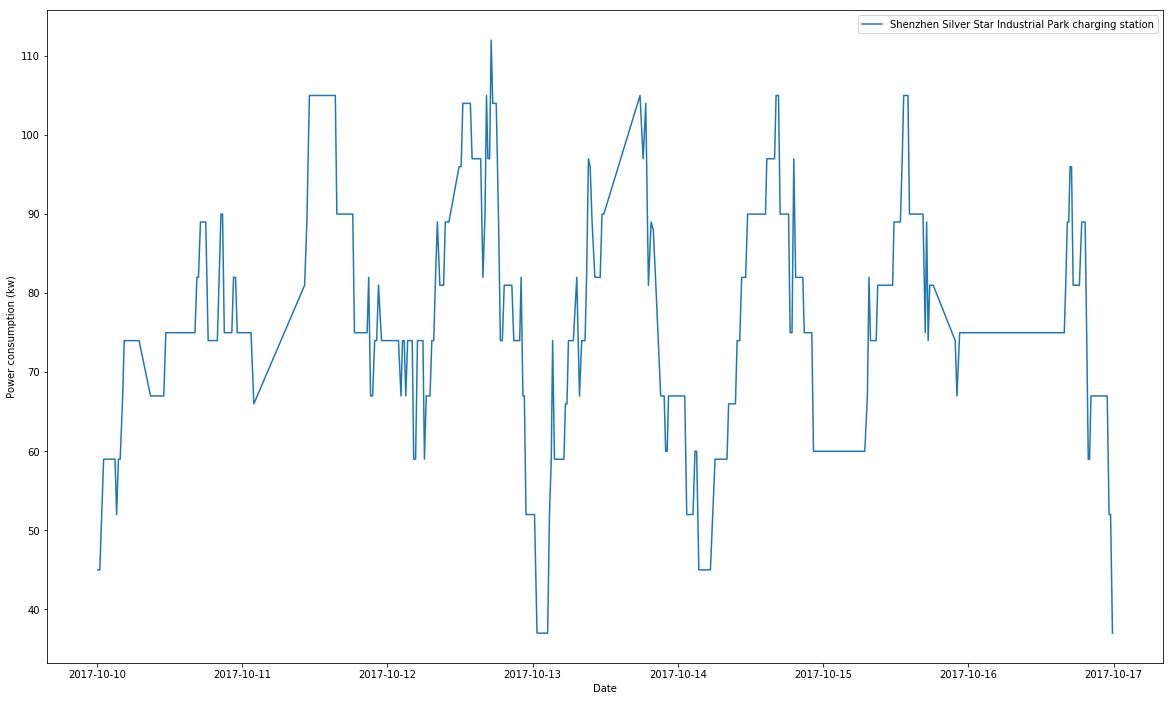

深圳万科九龙山充电站


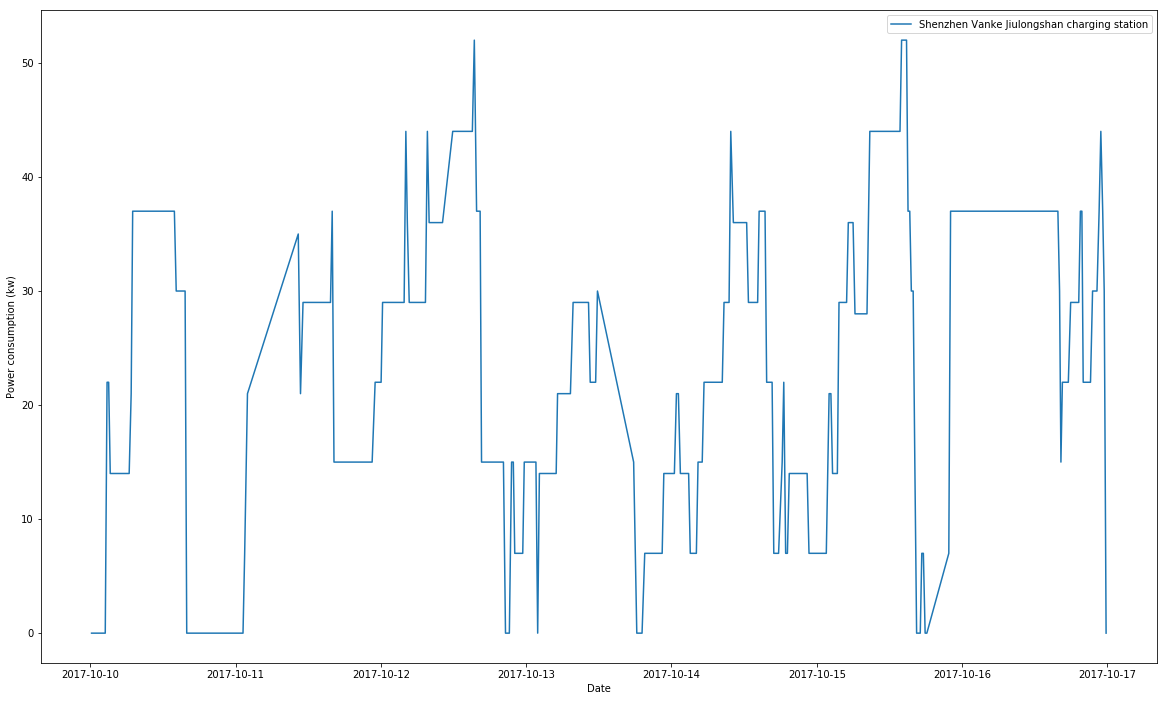

深圳景元大厦充电站


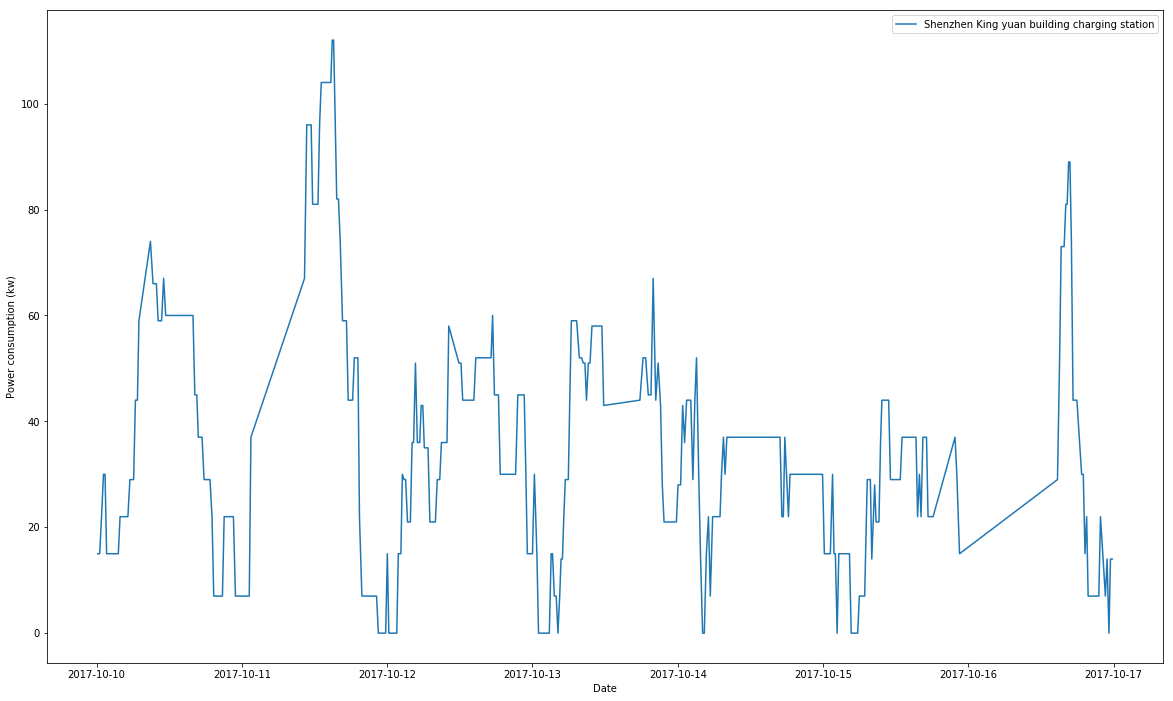

In [40]:
plt.close()
plt.figure(10, figsize=(20,12))
for counter, station in enumerate(staObject_list):
    plt.plot(date_power_sta_list[counter], occupy_power_sta_list[counter][length_prior_list[counter]:length_prior_list[counter]+len(date_power_sta_list[counter])], label=station.get_stationName_Eng())
plt.xlabel("Date")
plt.ylabel("Power consumption (kw)")
plt.legend()
plt.show()
for counter, station in enumerate(staObject_list):
    plt.figure(counter, figsize=(20,12))
    print(station.name)
    plt.plot(date_power_sta_list[counter], occupy_power_sta_list[counter][length_prior_list[counter]:length_prior_list[counter]+len(date_power_sta_list[counter])], label=station.get_stationName_Eng())
    plt.xlabel("Date")
    plt.ylabel("Power consumption (kw)")
    plt.legend()
    plt.show()
# plt.show()

## 6.4 Operation Daily Power Plot - one single station

In [74]:
def update_occupy_power_sta(station, year_lowerBound, year_upperBound, month_lowerBound, 
                            month_upperBound, day_lowerBound, day_upperBound):
    """
        occupy_power_sta, date_power_sta, length_prior_list
    """
    date_lowerBound = datetime.datetime(year_lowerBound, month_lowerBound, day_lowerBound, 
                                        tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-480, name=None))
    date_upperBound = datetime.datetime(year_upperBound, month_upperBound, day_upperBound, 
                                        tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-480, name=None))

    length_prior = check_num_prior(station, date_lowerBound)
    length_prior_list.append(length_prior)
    length_total = check_num_tot(station)

    occupy_power_sta = np.zeros(length_total)
    power_01 = 0
    #ac charger power
    power_ac_02 = 7  #kw
    power_ac_05 = 2  #kw
    #dc charge power
    power_dc_02 = 40 #kw
    power_dc_05 = 15 #kw
    for pill in station.pills:
        for i, data in enumerate(pill.ult_data):
            if int(data[0]) == 1 and  date_lowerBound < data[2] and date_upperBound > data[2]:
                occupy_power_sta[i]+=(power_01)
            elif int(data[0]) == 2 and date_lowerBound < data[2] and date_upperBound > data[2]:
                if len(pill.power) is 0:
                    occupy_power_sta[i]+=(power_ac_02)
                else:
                    occupy_power_sta[i]+=(power_dc_02)
            elif int(data[0]) == 5 and date_lowerBound < data[2] and date_upperBound > data[2]:
                if len(pill.power) is None:
                    occupy_power_sta[i]+=(power_ac_05)
                else:
                    occupy_power_sta[i]+=(power_dc_05)
    date_power_sta = [data[2] for data in station.pills[0].ult_data if 
                    date_lowerBound < data[2] and date_upperBound > data[2]]
#     pdb.set_trace ()
    return occupy_power_sta, date_power_sta, length_prior_list

In [236]:
station = YinXing_IndustrialPark_sta

#Specifying dates uppper and lower bounds
year_lowerBound = 2017
year_upperBound = 2017
month_lowerBound = 11
month_upperBound = 11
day_lowerBound = 1
day_range = 30

# check_overYear = False
# check_overMonth = False
# #Check if day_range is over the year 2017
# day2yearEnd = datetime.datetime(2017, 12, 31) - datetime.datetime(startYear, startMonth, day_lowerBound)
# if day_range > day2yearEnd.days:
#     check_overYear = True
# #Check if day_range is over the month
# if day_range > monthrange(startYear, startMonth)[-1]:
#     check_overMonth = True

occupy_power_sta_list = []
date_power_sta_list = []
length_prior_list = []
for day in range(day_range):
    if (month_lowerBound == 12) & (day_lowerBound == monthrange(year_lowerBound, month_lowerBound)[-1]):
        # Over the month and year. To the first day of next year 
        year_upperBound += 1
        month_upperBound = 1
        day_upperBound = 1
        # Run function to append values to occupy_power_sta_list and date_power_sta_list
        occupy_power_sta, date_power_sta, length_prior_list = update_occupy_power_sta(station, year_lowerBound, year_upperBound, 
                                                                   month_lowerBound, month_upperBound, 
                                                                   day_lowerBound, day_upperBound)
        occupy_power_sta_list.append(occupy_power_sta)
        date_power_sta_list.append(date_power_sta)
        year_lowerBound += 1
        month_lowerBound = 1
        day_lowerBound = 1
    elif day_lowerBound == monthrange(year_lowerBound, month_lowerBound)[-1]:
        # Over the month's length but still within the year
        month_upperBound += 1
        day_upperBound = 1
        # Run function to append values to occupy_power_sta_list and date_power_sta_list
        occupy_power_sta, date_power_sta, length_prior_list = update_occupy_power_sta(station, year_lowerBound, year_upperBound, 
                                                                   month_lowerBound, month_upperBound, 
                                                                   day_lowerBound, day_upperBound)
        occupy_power_sta_list.append(occupy_power_sta)
        date_power_sta_list.append(date_power_sta)
        month_lowerBound += 1
        day_lowerBound = 1
    else:
        # Within this month
        day_upperBound = day_lowerBound + 1
        # Run function to append values to occupy_power_sta_list and date_power_sta_list
        occupy_power_sta, date_power_sta, length_prior_list = update_occupy_power_sta(station, year_lowerBound, year_upperBound, 
                                                                   month_lowerBound, month_upperBound, 
                                                                   day_lowerBound, day_upperBound)
        occupy_power_sta_list.append(occupy_power_sta)
        date_power_sta_list.append(date_power_sta)
        day_lowerBound += 1

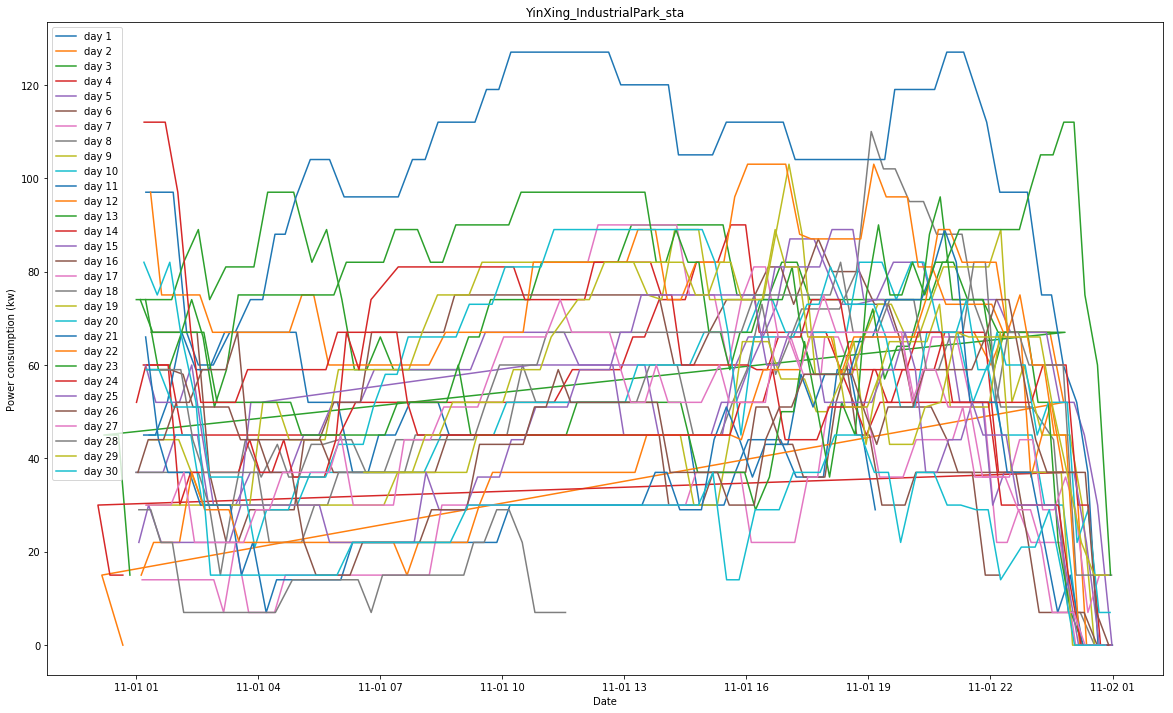

In [237]:
date_power_sta_list = convert_day(date_power_sta_list)
plt.figure(1, figsize=(20,12))
for counter in range(len(occupy_power_sta_list)):
    plt.plot(date_power_sta_list[counter], 
             occupy_power_sta_list[counter][length_prior_list[counter]:length_prior_list[counter]+len(date_power_sta_list[counter])], 
             label="day {}".format(counter+1))
plt.xlabel("Date")
plt.ylabel("Power consumption (kw)")
plt.legend()
plt.title("YinXing_IndustrialPark_sta")
plt.show()

In [238]:
timeOfPower = map_powerOfDay(date_power_sta_list, occupy_power_sta_list, length_prior_list, 15)
timeOfDay = create_timeOfDay(date_power_sta_list, 15)

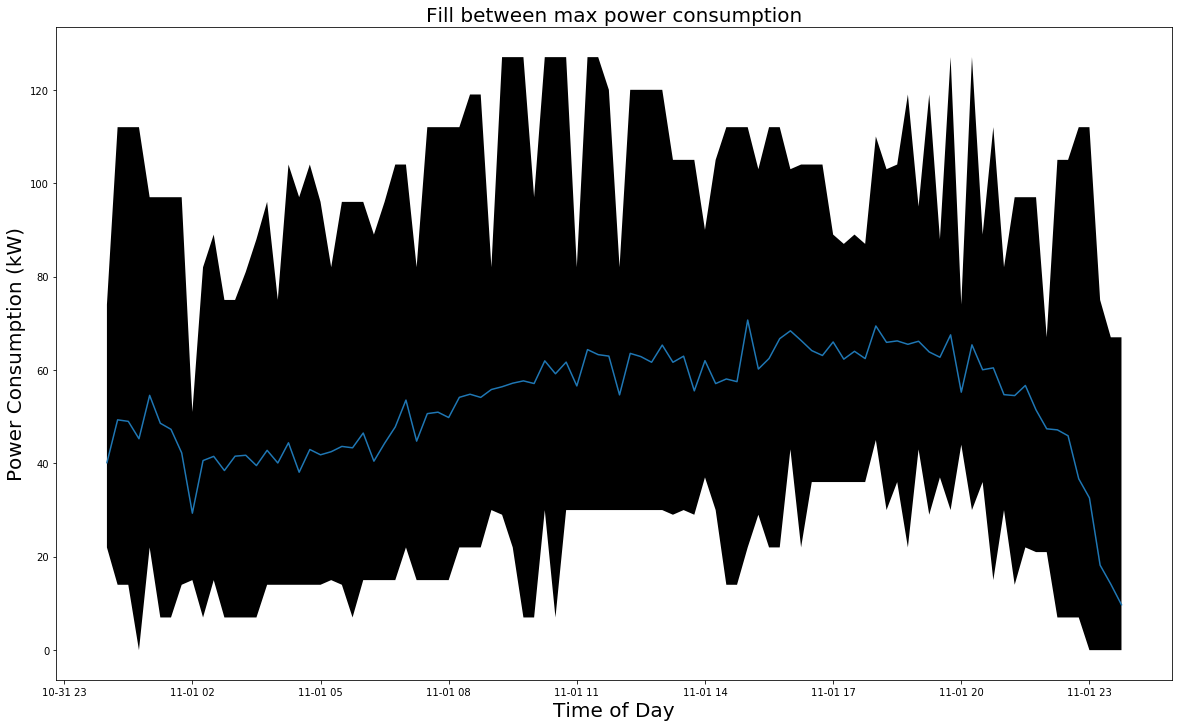

In [239]:
# Plot full power consumption data
avg_timeOfPower = get_avg_timeOfPower(timeOfPower, 15)
plt.figure(1, figsize=(20,12))
plt.plot(timeOfDay, avg_timeOfPower)
plt.fill_between(timeOfDay, [max(timeOfPower[i]) for i in range(96)], [min(timeOfPower[i]) for i in range(96)], facecolor='black')
plt.xlabel("Time of Day", fontdict={'fontsize':20})
plt.ylabel("Power Consumption (kW)", fontdict={'fontsize':20})
plt.title("Fill between max power consumption", fontdict={'fontsize':20})
plt.show()

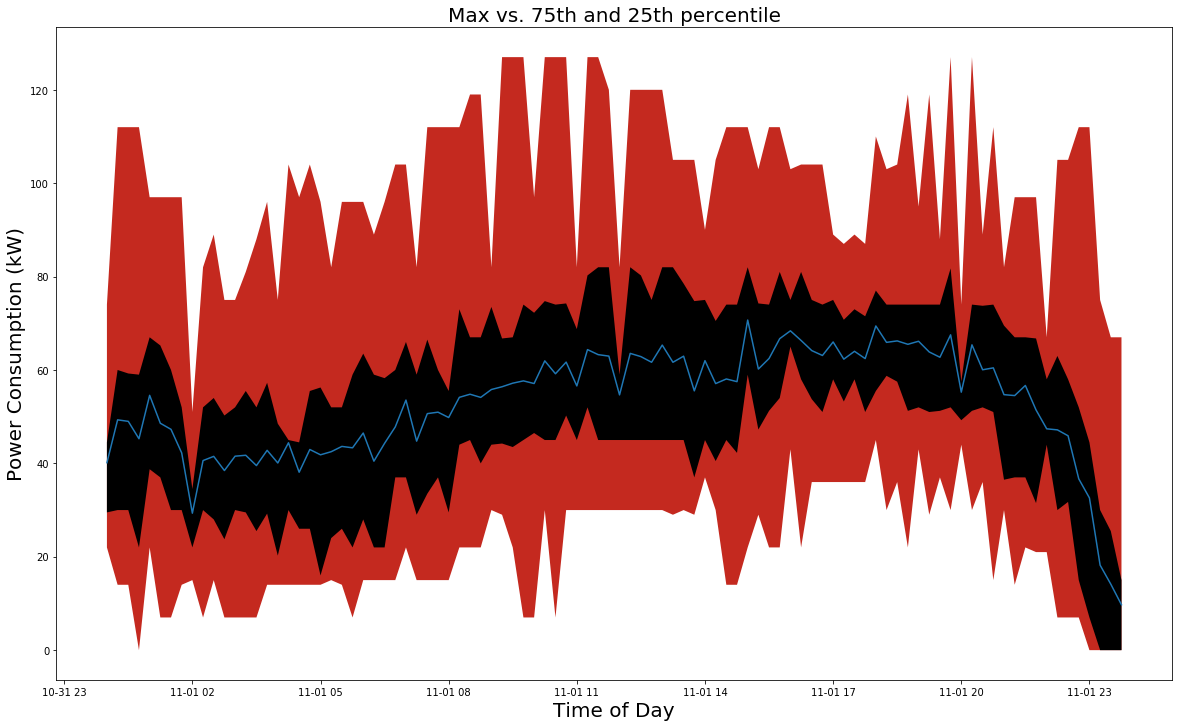

In [240]:
# Plot percentile power consumption data
avg_timeOfPower = get_avg_timeOfPower(timeOfPower, 15)
plt.figure(1, figsize=(20,12))
plt.plot(timeOfDay, avg_timeOfPower)
plt.fill_between(timeOfDay, [max(timeOfPower[i]) for i in range(96)], [min(timeOfPower[i]) for i in range(96)], facecolor='#C4291F')
plt.fill_between(timeOfDay, [np.percentile(timeOfPower[i], 75) for i in range(96)], [np.percentile(timeOfPower[i], 25) for i in range(96)], facecolor='black')
plt.xlabel("Time of Day", fontdict={'fontsize':20})
plt.ylabel("Power Consumption (kW)", fontdict={'fontsize':20})
plt.title("Max vs. 75th and 25th percentile", fontdict={'fontsize':20})
plt.show()

## 6.5 Operation Daily Power Plot - Eight stations

In [132]:
def plot_operationDailyPower(staObject_list, duration=30, yr_lo=2017, mo_lo=10, d_lo=10, timestamp_init=15, pen=1, save=0, eng=0):
    """
    Plot as titled.
    staObject_list - list with fully constructed station objects
    day_lowerBound - analysis starting from the day
    duration - analysis length of the day
    timestamp - time interval of data
    pen - Boolean with where you want to know about EV penetration
    save - Boolean with whether you want to save figures
    eng - Boolean with whether you want to store the figure with english station name
    """
    
    timestamp = timestamp_init
    buckets = int(24*60/timestamp) 
    
    for station in staObject_list:
        #Specifying dates uppper and lower bounds
        year_lowerBound = yr_lo
        year_upperBound = yr_lo
        month_lowerBound = mo_lo
        month_upperBound = mo_lo
        day_lowerBound = d_lo
        day_range = duration
        
        occupy_power_sta_list = []
        date_power_sta_list = []
        length_prior_list = []
        for day in range(day_range):
            if (month_lowerBound == 12) & (day_lowerBound == monthrange(year_lowerBound, month_lowerBound)[-1]):
                # Over the month and year. To the first day of next year 
                year_upperBound += 1
                month_upperBound = 1
                day_upperBound = 1
                # Run function to append values to occupy_power_sta_list and date_power_sta_list
                occupy_power_sta, date_power_sta, length_prior_list = update_occupy_power_sta(station, year_lowerBound, year_upperBound, 
                                                                           month_lowerBound, month_upperBound, 
                                                                           day_lowerBound, day_upperBound)
                occupy_power_sta_list.append(occupy_power_sta)
                date_power_sta_list.append(date_power_sta)
                year_lowerBound += 1
                month_lowerBound = 1
                day_lowerBound = 1
            elif day_lowerBound == monthrange(year_lowerBound, month_lowerBound)[-1]:
                # Over the month's length but still within the year
                month_upperBound += 1
                day_upperBound = 1
                # Run function to append values to occupy_power_sta_list and date_power_sta_list
                occupy_power_sta, date_power_sta, length_prior_list = update_occupy_power_sta(station, year_lowerBound, year_upperBound, 
                                                                           month_lowerBound, month_upperBound, 
                                                                           day_lowerBound, day_upperBound)
                occupy_power_sta_list.append(occupy_power_sta)
                date_power_sta_list.append(date_power_sta)
                month_lowerBound += 1
                day_lowerBound = 1
            else:
                # Within this month
                day_upperBound = day_lowerBound + 1
                # Run function to append values to occupy_power_sta_list and date_power_sta_list
                occupy_power_sta, date_power_sta, length_prior_list = update_occupy_power_sta(station, year_lowerBound, year_upperBound, 
                                                                           month_lowerBound, month_upperBound, 
                                                                           day_lowerBound, day_upperBound)
                occupy_power_sta_list.append(occupy_power_sta)
                date_power_sta_list.append(date_power_sta)
                day_lowerBound += 1
#         pdb.set_trace()
        if len(date_power_sta_list[0]) == 0:
            pass
        else:
            # Map date to same day    
            date_power_sta_list = convert_day(date_power_sta_list)
            timeOfPower = map_powerOfDay(date_power_sta_list, occupy_power_sta_list, length_prior_list, timestamp)
            timeOfDay = create_timeOfDay(date_power_sta_list, timestamp)

            #Calculte EV penetration
            avg_timeOfPower = get_avg_timeOfPower(timeOfPower, timestamp)
            penetration = np.divide(avg_timeOfPower, station.get_maxPower())*100 #percentage
            #Plot percentile power consumption data
            if pen:
                fig, ax1 = plt.subplots(figsize=(20,12))
                ax2 = ax1.twinx()
                ax1.plot(timeOfDay, avg_timeOfPower, label="Average Power Consumption (kW)", color="blue")
                ax1.fill_between(timeOfDay, [max(timeOfPower[i]) for i in range(buckets)], [min(timeOfPower[i]) for i in range(buckets)], facecolor='#C4291F')
                ax1.fill_between(timeOfDay, [np.percentile(timeOfPower[i], 75) for i in range(buckets)], [np.percentile(timeOfPower[i], 25) for i in range(buckets)], facecolor='black')
                ax1.set_xlabel("Time of Day", fontdict={'fontsize':20})
                ax1.set_ylabel("Power Consumption (kW)", fontdict={'fontsize':20})
                ax1.set_ybound(lower=0)

                ax2.plot(timeOfDay, penetration, label="EV penetration rate (%)", color="#c1a481")
                ax2.set_ylabel("EV Penetration (%)", fontdict={'fontsize':20})
                ax2.set_ybound(0, max(penetration)+10)

                ax1.legend(loc='upper right', bbox_to_anchor=(1, 1))
                ax2.legend(loc='upper right', bbox_to_anchor=(0.8, 1))
                ax1.set_title("Max vs. 75th and 25th percentile + EV Penetration", fontdict={'fontsize':20})
                if save:
                    if eng:
                        plt.savefig("{}+Penetration.png".format(station.get_stationName_Eng()))
                    else:
                        plt.savefig(station.name+"+penetration")
            else:
                plt.figure(1, figsize=(20,12))
                plt.plot(timeOfDay, avg_timeOfPower, label="Average Power Consumption (kW)")
                plt.fill_between(timeOfDay, [max(timeOfPower[i]) for i in range(buckets)], [min(timeOfPower[i]) for i in range(buckets)], facecolor='#C4291F')
                plt.fill_between(timeOfDay, [np.percentile(timeOfPower[i], 75) for i in range(buckets)], [np.percentile(timeOfPower[i], 25) for i in range(buckets)], facecolor='black')
                plt.xlabel("Time of Day", fontdict={'fontsize':20})
                plt.ylabel("Power Consumption (kW)", fontdict={'fontsize':20})
                plt.ylim(ymin=0)
                plt.title("Max vs. 75th and 25th percentile", fontdict={'fontsize':20})
                plt.legend()
                if save:
                    if eng:
                        plt.savefig("{}.png".format(station.get_stationName_Eng()))
                    else:
                        plt.savefig(station.name)

            print(station.name)
            print(station.get_stationName_Eng())
            plt.show()

深圳万科九龙山充电站
Shenzhen Vanke Jiulongshan charging station


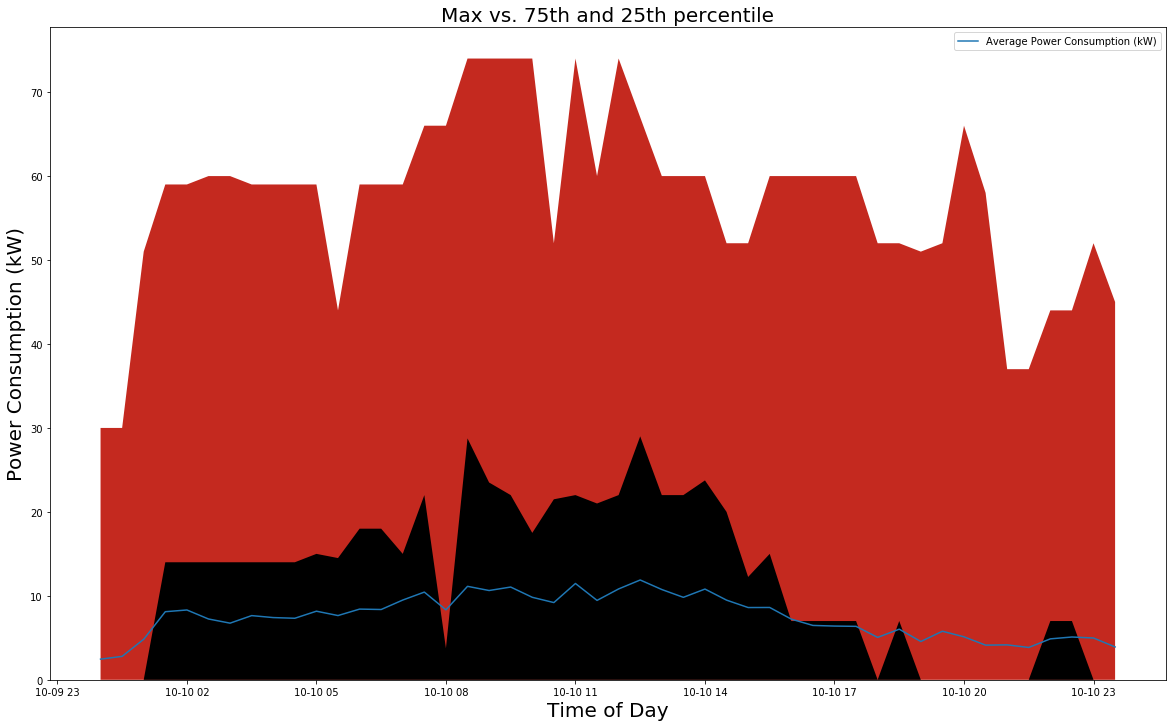

深圳景元大厦充电站
Shenzhen King yuan building charging station


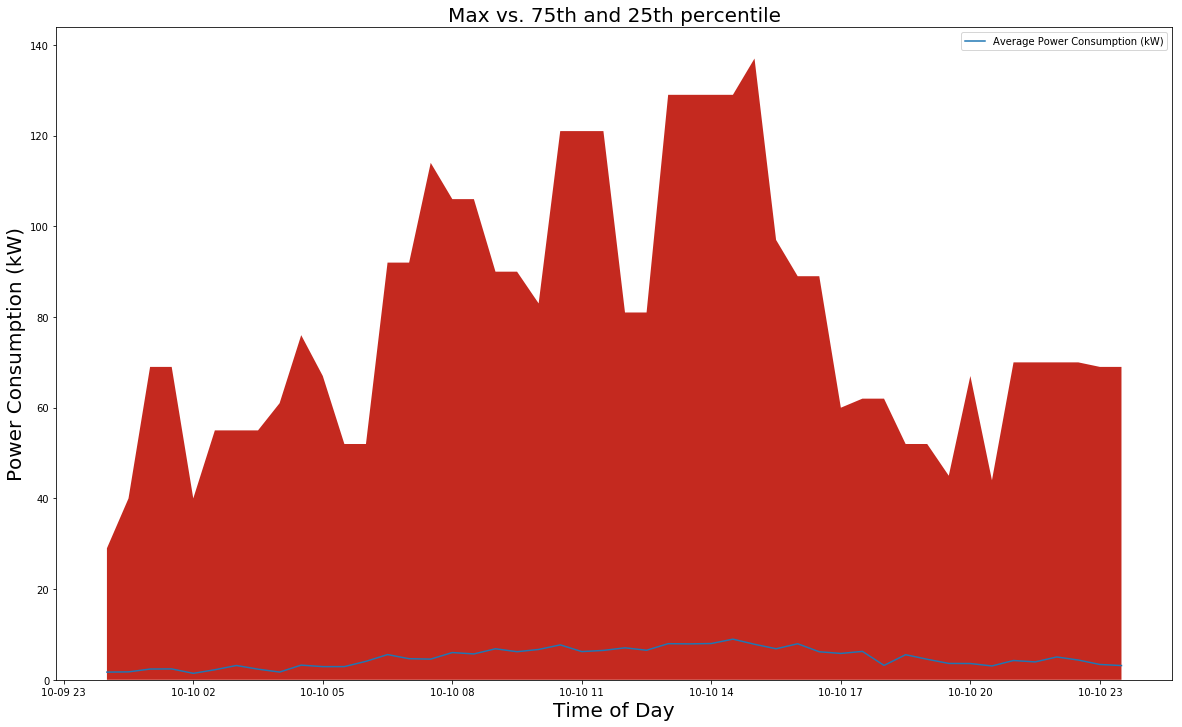

In [110]:
plot_operationDailyPower(staObject_list[-2:], duration=90, yr_lo=2017, mo_lo=10, d_lo=10, timestamp_init=30, pen=0)
# plt.close()
# main(sta_list, timestamp_init=15, day_lowerBound_init=8, duration=22,pen=1, save=0, eng=0)

# Main

In [113]:
def main(sta_list, duration=30, yr_lo=2017, mo_lo=10, d_lo=10, timestamp_init=15, pen=0, save=0, eng=0):
    #Request data from server
    print("Querying from server")
    pillcode_list, pill_details_list, sta_details_list = get_pill_station_details(sta_list)
    #Initialize station objects
    print("Initializing..")
    staObject_list = init_station_obj(sta_list, sta_details_list)
    #Construct full station objects
    print("Constructing..")
    staObject_list = constr_station_objFull(staObject_list, pillcode_list)
    #Update utilization data to pills of stations
    print("Updating..")
    staObject_list = update_daily_ultData(staObject_list)
    #Data visualization
    print("Let's make a plot")
    pdb.set_trace()
    plot_operationDailyPower(staObject_list, duration, yr_lo, mo_lo, d_lo, timestamp_init, pen, save, eng)

In [220]:
db_name="db_teld"
user_name="postgres"
password = "ecalscraping"
host="169.229.157.40"
port="5432"
conn = indb.init_db(db_name, user_name, password, host, port)

In [221]:
main(sta_list_clean[3:5], timestamp_init=30)

Querying from server
Initializing..
Constructing..
Updating..
Let's make a plot
> <ipython-input-113-511f80c62e94>(17)main()
-> plot_operationDailyPower(staObject_list, duration, yr_lo, mo_lo, d_lo, timestamp_init, pen, save, eng)
(Pdb) continue


In [233]:
pillcode_list, pill_details_list, sta_details_list = get_pill_station_details(sta_list_clean[3:5])
staObject_list = init_station_obj(sta_list[0:2], sta_details_list)
staObject_list = constr_station_objFull(staObject_list, pillcode_list)
staObject_list = update_daily_ultData(staObject_list)

In [241]:
def find_timeIdx(dateTime, timestamp=15):
    """
    timestamp - assuming multiple of 15 (minutes)
    Boundaries and intervals:
        52:31 -- [00:00] -- 7:30 --> Index 0 
        7:31 -- [15:00] -- 22:30 --> Index 1
        22:31 -- [30:00] -- 37:30 --> Index 2
        37:31 -- [45:00] -- 52:30 --> Index 3
    """
    if dateTime.tzinfo._offset.seconds == 61200:
        offset = -420
    elif dateTime.tzinfo._offset.seconds == 57600:
        offset = -480
    if timestamp == 15:
#         pdb.set_trace()
        if dateTime.day - 1 == 0:
            if dateTime.month - 1 == 0:
                # First interval of a new calendar year
                if dateTime.hour == 0 and datetime.datetime(dateTime.year-1, 12, 31, 23, 52, 31, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 7, 30, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)):
                    return 0
            else:
                # First interval of a new month
                dayEnd = monthrange(dateTime.year, dateTime.month-1)[-1]
                if dateTime.hour == 0 and datetime.datetime(dateTime.year, dateTime.month-1, dayEnd, 23, 52, 31, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 7, 30, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)):
                    return 0
                elif dateTime.hour != 0 and datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour-1, 52, 31, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 7, 30, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)):
                    return dateTime.hour*4
                else:
                    if datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 7, 31, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 22, 30, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)): 
                        return dateTime.hour*4 + 1
                    elif datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 22, 31, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 37, 30, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)): 
                        return dateTime.hour*4 + 2
                    else: 
                        return dateTime.hour*4 + 3
        if dateTime.hour == 0 and datetime.datetime(dateTime.year, dateTime.month, dateTime.day-1, 23, 52, 31, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 7, 30, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)):
            # If dateTime is in the first interval but involves previous day as boundary
            return 0
        elif dateTime.hour != 0 and datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour-1, 52, 31, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 7, 30, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)):
            return dateTime.hour*4
        else:
            if datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 7, 31, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 22, 30, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)): 
                return dateTime.hour*4 + 1
            elif datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 22, 31, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 37, 30, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)): 
                return dateTime.hour*4 + 2
            else: 
                return dateTime.hour*4 + 3
    elif timestamp == 30:
        if dateTime.day - 1 == 0:
            if dateTime.month - 1 == 0:
                # First interval of a new calendar year
                if dateTime.hour == 0 and datetime.datetime(dateTime.year-1, 12, 31, 23, 45, 1, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 15, 0, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)):
                    return 0
            else:
                # First interval of a new month
                dayEnd = monthrange(dateTime.year, dateTime.month-1)[-1]
                if dateTime.hour == 0 and datetime.datetime(dateTime.year, dateTime.month-1, dayEnd, 23, 45, 1, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 15, 0, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)):
                    return 0
                elif dateTime.hour != 0 and datetime.datetime(dateTime.year, dateTime.month-1, dayEnd, dateTime.hour-1, 45, 1, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 15, 0, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)):
                    return dateTime.hour*2
                else:
                    if datetime.datetime(dateTime.year, dateTime.month-1, dayEnd, dateTime.hour, 15, 0, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 45, 1, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)): 
                        return dateTime.hour*2 + 1
                    else:
                        if dateTime.hour == 23:
                            return dateTime.hour*2 + 1
                        return dateTime.hour*2 + 2
        if dateTime.hour == 0 and datetime.datetime(dateTime.year, dateTime.month, dateTime.day-1, 23, 45, 1, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 15, 0, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)):
            # If dateTime is in the first interval but involves previous day as boundary
            return 0
        elif dateTime.hour != 0 and datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour-1, 45, 1, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 15, 0, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)):
            return dateTime.hour*2
        else:
            if datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 15, 0, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)) < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 45, 1, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=offset, name=None)): 
                return dateTime.hour*2 + 1
            else:
                if dateTime.hour == 23:
                    return dateTime.hour*2 + 1
                return dateTime.hour*2 + 2

In [225]:
def map_powerOfDay(date_power_sta_list, occupy_power_sta_list, length_prior_list, timestamp=15):
    """
    timestamp - assuming multiple of 15 (minutes)
    """
    buckets = int(24*60/timestamp)
    timeOfPower = [[] for i in range(buckets)]
    for pwr_counter, occupy_power_sta in enumerate(occupy_power_sta_list):
        for time_counter, date in enumerate(date_power_sta_list[pwr_counter]):
            try:
                index = find_timeIdx(date, timestamp)
#                 pdb.set_trace()
                timeOfPower[index].append(occupy_power_sta[length_prior_list[pwr_counter]:length_prior_list[pwr_counter]+len(date_power_sta_list[pwr_counter])][time_counter])
            except:
                pdb.set_trace()
                print(date)
                print(sys.exc_info())
#     pdb.set_trace()
    return timeOfPower

In [234]:
plot_operationDailyPower(staObject_list, duration=30, yr_lo=2017, mo_lo=11, d_lo=1, timestamp_init=15)

> <ipython-input-225-44fb0ebe9e8b>(15)map_powerOfDay()
-> print(date)
(Pdb) n
2017-11-01 01:49:33.069485-08:00
> <ipython-input-225-44fb0ebe9e8b>(16)map_powerOfDay()
-> print(sys.exc_info())
(Pdb) n
(<type 'exceptions.IndexError'>, IndexError('index 3 is out of bounds for axis 0 with size 3',), <traceback object at 0x11aa0fcf8>)
> <ipython-input-225-44fb0ebe9e8b>(8)map_powerOfDay()
-> for time_counter, date in enumerate(date_power_sta_list[pwr_counter]):
(Pdb) c
> <ipython-input-225-44fb0ebe9e8b>(15)map_powerOfDay()
-> print(date)
(Pdb) q


BdbQuit: 